In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


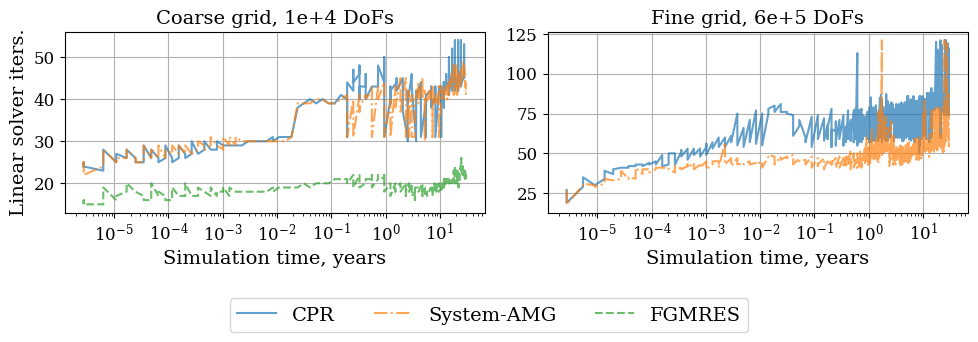

In [8]:
grids = [0.5, 5]

data = {}
names = {}
solvers = [
    "CPR",
    "SAMG",
    "FGMRES",
    # 'S4_diag',
]
colors = {name: f"C{i}" for i, name in enumerate(solvers)}


data = {}
names = {}
for i, g in enumerate(grids):
    data[i] = {}
    names[i] = f"Grid {g}"
    for s in solvers:
        try:
            data[i][s] = load_data(f"../stats/stats_thermal_geo5x{g}_sol{s}.json")
        except:
            continue

shape = [1, 2]
figsize = (10, 3)
DAY = 3600 * 24
YEAR = 365 * DAY

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    'axes.titlesize': 14,
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}

plt.rcParams.update(tex_fonts)

linestyles = {
    'CPR': '-',
    'SAMG': '-.',
    'FGMRES': '--'
}


def render_element(i, data):
    if len(data) == 0:
        return
    for solver_name, d in data.items():
        ts = np.cumsum(get_time_steps(d))
        ls = get_ls_indices(d)
        idx = np.where(ts[ls] / YEAR <= 30)[0]
        label = solver_name
        if label == 'SAMG':
            label = 'System-AMG'
        if label == 'FGMRES' and i == 1:
            continue
        plt.plot(
            ts[ls][idx] / YEAR,
            np.array(get_gmres_iterations(d))[idx],
            label=label,
            alpha=0.7,
            c=colors[solver_name],
            linestyle=linestyles[solver_name]
        )

    plt.grid()
    # if i == 1:
    #     plt.xlim(left=5e-5, right=800)
    plt.xscale("log")


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    legend=True,
    xlabel="Simulation time, years",
    ylabel="Linear solver iters.",
    ax_titles={0: "Coarse grid, 1e+4 DoFs", 1: "Fine grid, 6e+5 DoFs"},
)
plt.savefig('fig3d.svg', bbox_inches='tight')

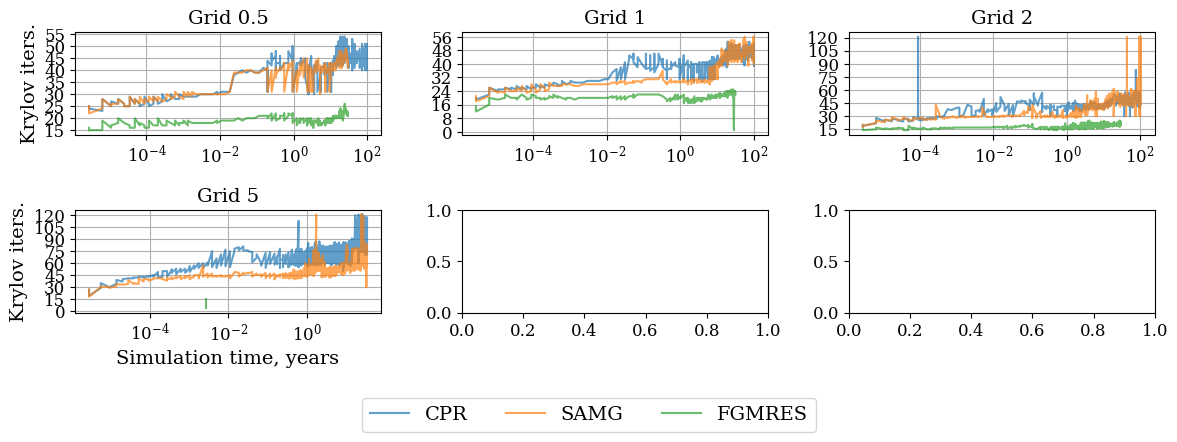

In [9]:
grids = [
    # 1,
    # 2,
    # 5,
    # 10,
    # 15,
    # 20,
    0.5,1,2,5,
]

data = {}
names = {}
solvers = [
    "CPR",
    "SAMG",
    "FGMRES",
    # 'S4_diag',
]
colors = {name: f"C{i}" for i, name in enumerate(solvers)}


data = {}
names = {}
for i, g in enumerate(grids):
    data[i] = {}
    names[i] = f"Grid {g}"
    for s in solvers:
        try:
            data[i][s] = load_data(f"../stats/stats_thermal_geo5x{g}_sol{s}.json")
        except:
            continue


shape = [2, 3]
figsize = (12, 4)

DAY = 3600 * 24
YEAR = 365 * DAY

def render_element(i, data):
    if len(data) == 0:
        return
    for solver_name, d in data.items():
        ts = np.cumsum(get_time_steps(d))
        ls = get_ls_indices(d)
        # color_converged_reason(d, legend=True)
        # plt.plot(get_gmres_iterations(d), label=solver_name, alpha=0.7, c=colors[solver_name])
        plt.plot(ts[ls] / YEAR, get_gmres_iterations(d), label=solver_name, alpha=0.7, c=colors[solver_name])

        # peclet_max = get_peclet_max(d)
        # peclet_mean = get_peclet_mean(d)
        # plt.plot(ts[ls] / YEAR, peclet_max, label=solver_name, alpha=0.7, c=colors[solver_name])
        # plt.ylim(0, 3000)

        # plt.twinx()
        # plt.yscale('log')
        # ls = get_ls_indices(d)
        # plt.plot(np.array(get_time_steps(d))[ls] / DAY , color='black', alpha=0.5, label='Time')
    plt.gca().grid(True)
    set_integer_ticks("vertical")
    # color_time_steps(data['CPR'], fill=True, legend=True)
    # plt.yscale('log')
    plt.xscale('log')


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names, xlabel='Simulation time, years'
)

TypeError: unsupported operand type(s) for +: 'TimeStepStats' and 'TimeStepStats'

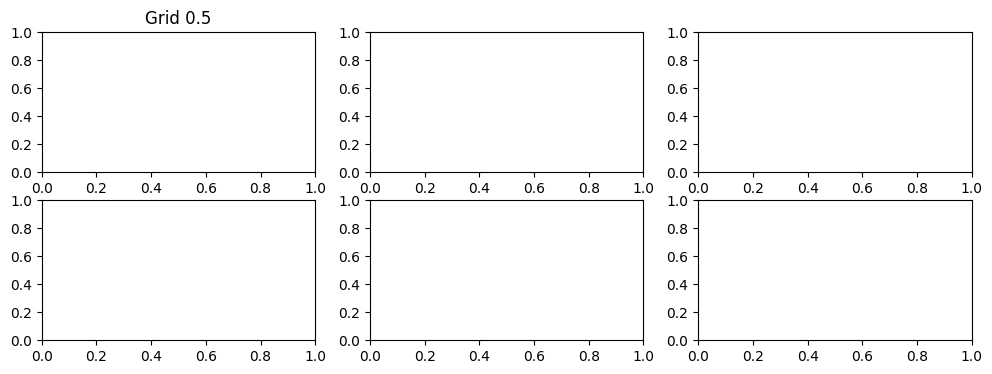

In [4]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    entry = entry.get('CPR')
    if entry is None:
        return
    ts = np.cumsum(get_time_steps(entry))
    ls = get_ls_indices(entry)

    st, sl, op = get_num_sticking_sliding_open(entry)
    total = st + sl + op
    frac_len_mean = np.mean(load_data(f"../stats/stats_thermal_geo5x{5}_sol{'CPR'}.json")) / 1000
    # color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.gca().grid(False)
    plt.gca().grid(True, which="major", axis="y")
    marker = None
    plt.plot(ts[ls] / YEAR, sl *frac_len_mean, label="Sliding", marker=marker, color=COLOR_SLIDING)
    # plt.plot(ts[ls] / YEAR, sl / total * 100, label="Sliding", marker=marker, color=COLOR_SLIDING)
    # plt.plot(ts[ls]/ YEAR, op / total * 100, label="Open", marker=marker, color=COLOR_OPEN)
    # print(ts[ls][-1] / YEAR)
    cfl = get_cfl(entry)
    peclet_max = get_peclet_max(entry)
    peclet_mean = get_peclet_mean(entry)
    diffusion = get_fourier_max(entry)
    convection = get_enthalpy_max(entry)
    # plt.twinx()
    # plt.plot(cfl, label='CFL')
    # plt.plot(diffusion, label=r'$P_{max}$')
    # plt.yscale('log')

plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="% fracture cells",
    xlabel='Simulation time, years',
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')


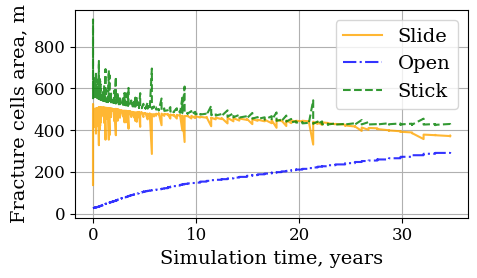

In [67]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(5,3))

entry = data[3]['CPR']
ts = np.cumsum(get_time_steps(entry))
ls = get_ls_indices(entry)

st, sl, op = get_num_sticking_sliding_open(entry)
total = st + sl + op
frac_len_mean = np.mean(load_data(f"../stats/dofs_info_stats_thermal_geo5x{5}_sol{'CPR'}.json")["cell_volumes"]) / 1000
plt.gca().grid(True)
marker = None
plt.plot(ts[ls] / YEAR, sl *frac_len_mean, label="Slide", marker=marker, alpha=0.8, color='orange', linestyle='-')
plt.plot(ts[ls]/ YEAR, op * frac_len_mean, label="Open", marker=marker, alpha=0.8, color='blue', linestyle='-.')
plt.plot(ts[ls]/ YEAR, st * frac_len_mean, label="Stick", marker=marker, alpha=0.8, color='green', linestyle='--')
plt.ylabel('Fracture cells area, m')
plt.xlabel('Simulation time, years')
plt.legend()
plt.tight_layout()
plt.savefig('fracture_cells_area.svg')

In [10]:
from collections import defaultdict
import pandas as pd

table = dict()

NDIGITS = 1

# solvers = ["CPR"]

for g in grids:
    table[g] = {}
    for s in solvers:
        stats_name = f"stats_thermal_geo5x{g}_sol{s}.json"
        try:
            entry = load_data(f"../stats/{stats_name}")
            dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
        except FileNotFoundError:
            continue
        total_dofs = dofs_info["total dofs"]
        table[g]["Total DoFs"] = f'{total_dofs:.0e}'

        ts = np.cumsum(get_time_steps(entry))
        ls = get_ls_indices(entry)
        idx = np.where(ts[ls] < 30 * YEAR)[0]
        table[g][s] = round(np.mean(np.array(get_gmres_iterations(entry))[idx]), NDIGITS)

        # if g in [1, 2, 5]:
        #     direct = load_data(f"../stats/stats_geo0x{g}_sol{21}_ph{1}_bb{2}_fr{1}.json")
        #     table["GMRES dir."].append(round(np.mean(get_gmres_iterations(direct)), NDIGITS))
        # else:
        #     table["GMRES dir."].append('-')

        # table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))
        converged_reason = get_petsc_converged_reason(entry)
        # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table)
table.rename(columns=table.iloc[0], inplace=True)
table = table[1:]
table.columns.name = 'Total DoFs'
table

Total DoFs,1e+04,3e+04,9e+04,6e+05
CPR,38.0,38.0,42.6,70.9
SAMG,38.3,33.6,37.2,51.0
FGMRES,19.5,20.7,18.7,9.5


In [8]:
print(table.to_latex(float_format=f'%.{NDIGITS}f'))

\begin{tabular}{lllll}
\toprule
Total DoFs & 1e+04 & 3e+04 & 9e+04 & 6e+05 \\
\midrule
CPR & 38.0 & 38.0 & 42.6 & 70.9 \\
SAMG & 36.8 & 33.6 & 37.2 & 51.0 \\
FGMRES & 19.5 & 20.7 & 18.7 & 9.5 \\
\bottomrule
\end{tabular}



In [ ]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_5 import make_model
import porepy as pp

model = make_model(
    {
        "geometry": 5,
        "grid_refinement": 1,
        "solver": 3,
        'steady_state': True,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]

In [ ]:
# mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
#     load_data(f"../stats/{model.simulation_name()}.json"), 9
# )

# mat = scipy.sparse.load_npz('../matrices/stats_thermal_geo5x10_sol3_1739045561550.npz')
# rhs = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_rhs.npy')
# iterate = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_iterate.npy')
# state = np.load('../matrices/stats_thermal_geo5x10_sol3_1739045561550_state.npy')
# dt = 4e-3

In [ ]:
# model.linear_system = mat, rhs
# model.bmat.mat = mat
# model.equation_system.set_variable_values(state, time_step_index=0)
# model.equation_system.set_variable_values(iterate, iterate_index=0)
# model.ad_time_step.set_value(dt)
# model.time_manager.dt = dt

In [ ]:
J = model.bmat[:]
J.plot_max()
J.shape

In [ ]:
from fixed_stress import make_fs_analytical, make_fs_analytical_slow_new
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *
from full_petsc_solver import *

contact = [0]
intf = [1, 2]
mech = [3, 4]
flow = [5, 6, 7]
temp = [8, 9, 10]
scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    inner=PetscKSPScheme(
        petsc_options={
            # "ksp_type": "fgmres",
            "ksp_monitor": None,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=contact,
            block_size=model.nd,
            fieldsplit_options={
                "pc_fieldsplit_schur_precondition": "selfp",
            },
            elim_options={
                "pc_type": "pbjacobi",
            },
            keep_options={
                "mat_schur_complement_ainv_type": "blockdiag",
            },
            complement=PetscFieldSplitScheme(
                groups=intf,
                elim_options={
                    "pc_type": "ilu",
                },
                fieldsplit_options={
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                complement=PetscFieldSplitScheme(
                    groups=mech,
                    elim_options=(
                        {
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                            "pc_hypre_boomeramg_smooth_type": "Euclid",
                        }
                    ),
                    keep_options={
                    },
                    block_size=model.nd,
                    invert=lambda bmat: csr_to_petsc(
                        make_fs_analytical_slow_new(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=flow + temp,
                        ).mat,
                        bsize=1,
                    ),
                    complement=PetscCPRScheme(
                        groups=flow + temp,
                        pressure_groups=flow,
                        pressure_options={
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                            "pc_hypre_boomeramg_smooth_type": "Euclid",
                        },
                        others_options={
                            "pc_type": "hypre",
                            "pc_hypre_type": "boomeramg",
                            "pc_hypre_boomeramg_strong_threshold": 0.7,
                        },
                        cpr_options={
                            "pc_composite_pcs": "fieldsplit,ksp",
                            "sub_1_ksp_ksp_type": "preonly",
                            "sub_1_ksp_pc_type": "hypre",
                            "sub_1_ksp_pc_hypre_type": "Euclid",
                        },
                    ),
                ),
            ),
        ),
    ),
)

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=scheme,
    ksp_view=True,
)

In [ ]:
from thermal.thm_solver import make_pt_permutation


scheme = LinearTransformedScheme(
    right_transformations=[lambda bmat: model.Qright(contact_group=0, u_intf_group=4)],
    left_transformations=[
        lambda bmat: model.scale_energy_balance(bmat),
    ],
    inner=PetscKSPScheme(
        petsc_options={
            # "ksp_type": "fgmres",
            "ksp_monitor": None,
            "ksp_rtol": 1e-12,
        },
        compute_eigenvalues=True,
        preconditioner=PetscFieldSplitScheme(
            groups=contact,
            block_size=model.nd,
            fieldsplit_options={
                "pc_fieldsplit_schur_precondition": "selfp",
            },
            elim_options={
                "pc_type": "pbjacobi",
            },
            keep_options={
                "mat_schur_complement_ainv_type": "blockdiag",
            },
            complement=PetscFieldSplitScheme(
                groups=intf,
                elim_options={
                    "pc_type": "ilu",
                },
                fieldsplit_options={
                    "pc_fieldsplit_schur_precondition": "selfp",
                },
                complement=PetscFieldSplitScheme(
                    groups=mech,
                    elim_options=(
                        {
                            # 'pc_type': 'gamg',
                            # "pc_type": "hypre",
                            # "pc_hypre_type": "boomeramg",
                            # "pc_hypre_boomeramg_strong_threshold": 0.7,
                            # 'pc_hypre_boomeramg_max_row_sum': 1.0,
                            # "pc_hypre_boomeramg_smooth_type": "Euclid",
                            "pc_type": "hmg",
                            "hmg_inner_pc_type": "hypre",
                            # "hmg_inner_pc_hypre_type": "boomeramg",
                            # 'hmg_inner_pc_type': 'gamg',
                            # 'hmg_inner_pc_gamg_threshold': 0.1,
                            "hmg_inner_pc_hypre_boomeramg_strong_threshold": 0.75,
                            "mg_levels_ksp_type": "richardson",
                            "mg_levels_ksp_max_it": 2,
                            'mg_levels_pc_type': 'ilu',
                        }
                    ),
                    keep_options={},
                    block_size=model.nd,
                    invert=lambda bmat: csr_to_petsc(
                        make_fs_analytical_slow_new(
                            model,
                            bmat,
                            p_mat_group=5,
                            p_frac_group=6,
                            groups=flow + temp,
                        ).mat,
                        bsize=1,
                    ),
                    complement=PetscCompositeScheme(
                        groups=flow + temp,
                        solvers=[
                            PetscFieldSplitScheme(
                                groups=flow,
                                fieldsplit_options={
                                    "pc_fieldsplit_type": "additive",
                                },
                                elim_options={
                                    "pc_type": "hypre",
                                    "pc_hypre_type": "boomeramg",
                                    "pc_hypre_boomeramg_strong_threshold": 0.7,
                                },
                                complement=PetscFieldSplitScheme(
                                    groups=temp,
                                    elim_options={
                                        "pc_type": "none",
                                    },
                                ),
                            ),
                            PetscFieldSplitScheme(
                                groups=flow + temp,
                                python_pc=lambda bmat: PcPythonPermutation(
                                    make_pt_permutation(
                                        bmat, p_groups=flow, t_groups=temp
                                    ),
                                    block_size=2,
                                ),
                                elim_options={
                                    # "python_pc_type": "ilu",
                                    "python_pc_type": "hypre",
                                    "python_pc_hypre_type": "Euclid",
                                },
                            ),
                        ],
                    ),
                ),
            ),
        ),
    ),
)
solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=scheme,
    ksp_view=True,
)